<a href="https://colab.research.google.com/github/quangphuc2509/Machinevision/blob/main/facetrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Khai báo và sử dụng các thư viện sau
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from IPython.display import clear_output

In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
#
def ResNet34(shape = (300, 300, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
model = ResNet34()
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 153, 153, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
# Load Dataset

dataset_url = r'/content/drive/MyDrive/xla/faceData'
data_dir = pathlib.Path(dataset_url)

batch_size = 100
img_height = 300
img_width = 300

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 37,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  color_mode="rgb")

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 37,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  color_mode="rgb")

Found 1007 files belonging to 2 classes.
Using 806 files for training.
Found 1007 files belonging to 2 classes.
Using 201 files for validation.


In [ ]:
classes = train_ds.class_names
print(classes)

['Phuc', 'unknow']


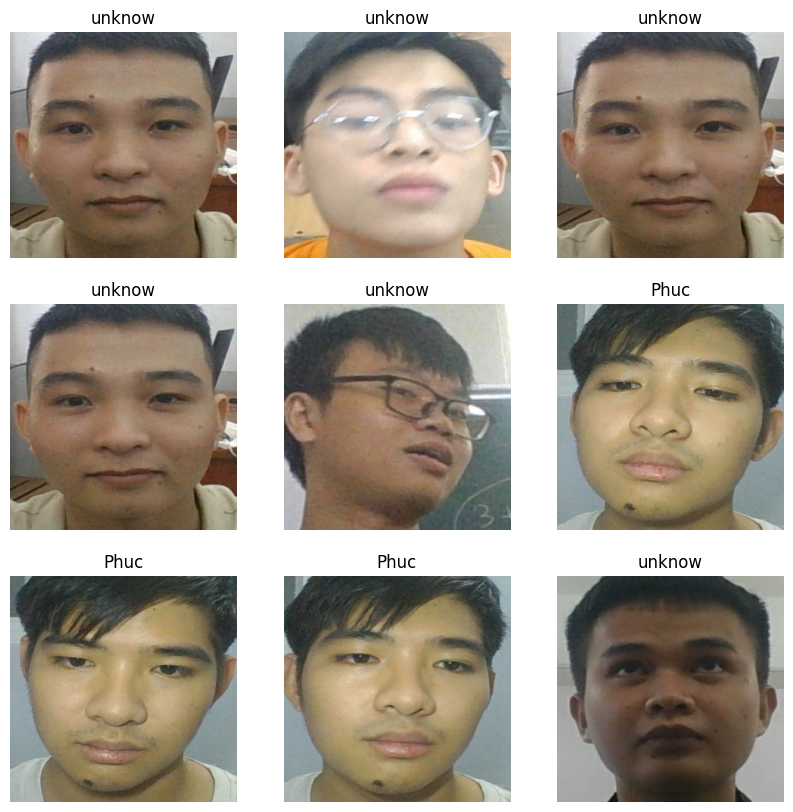

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 300, 300, 3)
(100,)


In [ ]:
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait = True)

callbacks = [DisplayCallback(), 
            EarlyStopping(patience = 11, verbose = 1),
            ReduceLROnPlateau(patience = 3, verbose = 1),
            ModelCheckpoint('/content/drive/MyDrive/xla/face1.h5', verbose = 1, save_best_only = True)]

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
          train_ds,
          validation_data = val_ds,
          epochs = 100,
          callbacks = callbacks
        )


Epoch 62: val_loss did not improve from 0.11121
9/9 [==============================] - 11s 1s/step - loss: 0.1221 - accuracy: 0.9665 - val_loss: 0.1147 - val_accuracy: 0.9801 - lr: 1.0000e-09
Epoch 62: early stopping


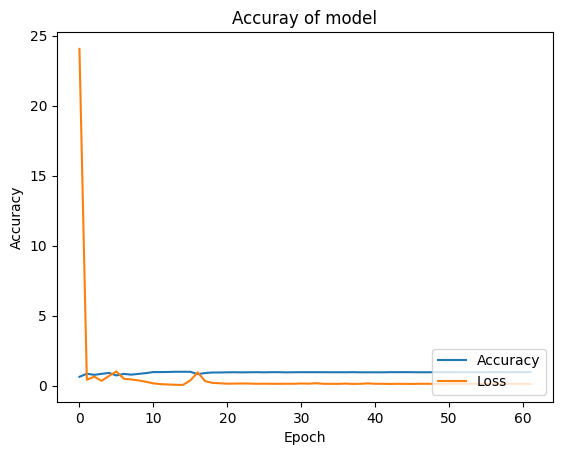

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Accuray of model")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend(["Accuracy", "Loss"], loc = "lower right")

In [ ]:
# Đánh giá độ chính xác của mô hình 
Score=model.evaluate(val_ds,verbose=0)
print('Loss', Score[0])
print('Accuracy', Score[1])


Loss 0.11469189077615738
Accuracy 0.9800994992256165
